### Using FISSA with SIMA
SIMA is a fully featured toolbox including motion correction and cell detection. Here we illustrate how one can integrate FISSA into their workflow.

For more information about the SIMA toolbox see: 

http://www.losonczylab.org/sima/

Kaifosh, P., Zaremba, J. D., Danielson, N. B., Losonczy, A., 2014. SIMA: Python software for analysis of dynamic fluorescence imaging data. Frontiers in neuroinformatics 8 (80)

#### Imports

In [1]:
# SIMA
import sima
import sima.segment

# Plotting toolbox
import holoviews as hv
%load_ext holoviews.ipython

# file operations
import glob

# FISSA
import fissa

/usr/local/lib/python2.7/dist-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


Plotting option so plots are embedded not rendered live

In [2]:
%output widgets='embed'

#### Setup data

In [3]:
# Define folder where tiffs are present
tiff_folder = 'exampleData/20150529/'

# Find tiffs in folder
tiffs  = sorted(glob.glob(tiff_folder + '/*.tif*'))

# define motion correction method
mc_approach = sima.motion.DiscreteFourier2D()

# define SIMA dataset
sequences = [sima.Sequence.create('TIFF', tiff) for tiff in tiffs[:1]]
try:
    dataset = sima.ImagingDataset(sequences, 'example.sima')
except:
    dataset = sima.ImagingDataset.load('example.sima')

#### Detect cells with sima

In [4]:
stica_approach = sima.segment.STICA(components=2)
stica_approach.append(sima.segment.SparseROIsFromMasks())
stica_approach.append(sima.segment.SmoothROIBoundaries())
stica_approach.append(sima.segment.MergeOverlapping(threshold=0.5))
rois = dataset.segment(stica_approach, 'auto_ROIs')

#### Show detected cells

:Overlay
   .Curve.I   :Curve   [x]   (y)
   .Curve.II  :Curve   [x]   (y)
   .Curve.III :Curve   [x]   (y)
   .Curve.IV  :Curve   [x]   (y)
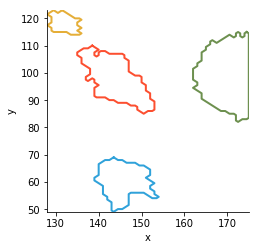

In [5]:
fig = hv.Overlay()
for i in range(len(rois)):
    fig *= hv.Curve(rois[i].coords[0][:, 1::-1])

fig

#### Use FISSA with SIMA detected cells

FISSA needs either ImageJ ROIs or numpy arrays as inputs for the ROIs. 

SIMA outputs ROIs as numpy arrays, and can be directly read into FISSA.
A given roi is given as

```
rois[i].coords[0][:,:2]
```

FISSA expects a set of rois to be given as a list of lists

```
[[roiA1,roiA2,roiA3...]]
```
So some formatting will need to be done first.

In [6]:
numROI = len(rois)
rois_FISSA = [rois[i].coords[0][:, :2] for i in range(numROI)]

In [7]:
rois[i].coords[0][:, :2].shape

(40, 2)

Which can then be put into FISSA and run

In [8]:
output_folder = 'fissa_sima_example'
exp = fissa.Experiment(tiff_folder, [rois_FISSA], output_folder)
exp.separate()

Reloading previously prepared data...
Reloading previously separated data...
Reloading previously prepared data...
Reloading previously separated data...


#### Plotting the results

:Layout
   .HoloMap.I  :HoloMap   [Cell]
      :Overlay
         .Curve.I    :Curve   [x]   (y)
         .Curve.II   :Curve   [x]   (y)
         .Curve.III  :Curve   [x]   (y)
         .Curve.IV   :Curve   [x]   (y)
         .Curve.V    :Curve   [x]   (y)
         .Curve.VI   :Curve   [x]   (y)
         .Curve.VII  :Curve   [x]   (y)
         .Curve.VIII :Curve   [x]   (y)
         .Curve.IX   :Curve   [x]   (y)
   .HoloMap.II :HoloMap   [Cell]
      :Overlay
         .Curve.SIMA  :Curve   [x]   (y)
         .Curve.FISSA :Curve   [x]   (y)
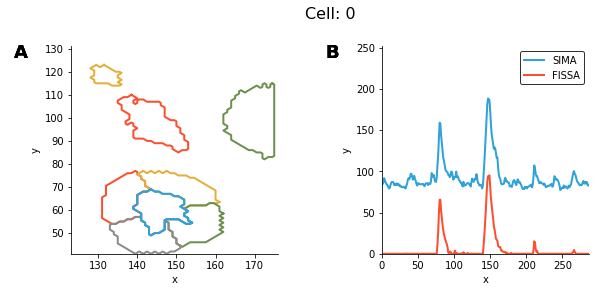
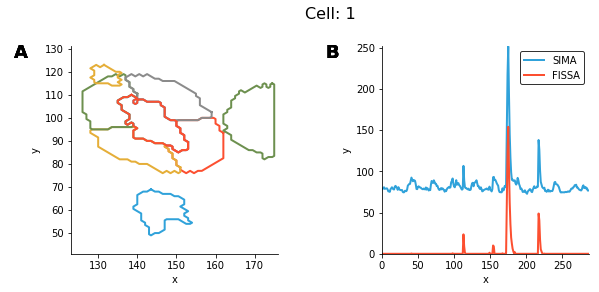
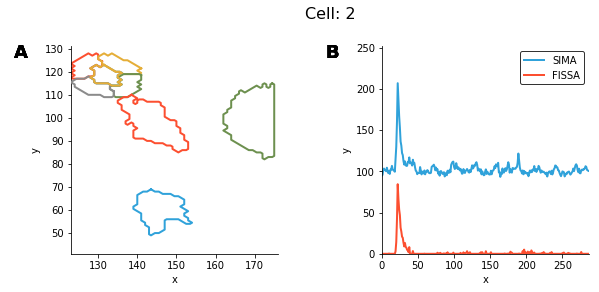
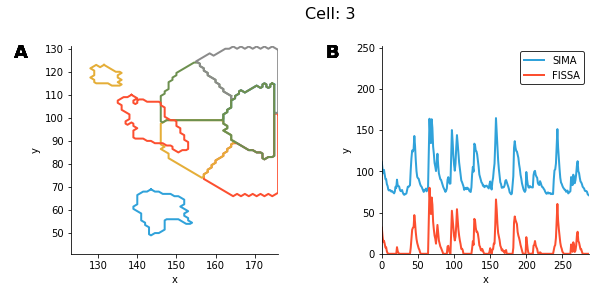

In [9]:
%%opts Curve {+axiswise}
# function for a single cell region plot
def plot_cell_regions(cell):
    out = hv.Overlay()
    numReg = len(exp.roi_polys[cell, 0])  # Number of regions
    for i in range(numReg):
        out *= hv.Curve(exp.roi_polys[cell, 0][i][0])
    return out

# get plots for all detected regions
region_plots = {i : plot_cell_regions(i) for i in range(exp.nCell)}

# get plots for raw extracts and neuropil removed
traces_plots = {i : hv.Curve(exp.raw[i][1][0, :], label='SIMA') * hv.Curve(exp.result[i][1][0, :], label='FISSA') for i in range(exp.nCell)}

hv.HoloMap(region_plots,kdims=['Cell']) * fig + hv.HoloMap(traces_plots,kdims=['Cell'])

(A) ROI contours, and the neuropil subregions defined by FISSA for the current cell.

(B) Signal extracted by SIMA's detected ROI (blue), and after FISSA (red)